1. Data Preparation

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Download historical data from Yahoo Finance
data = yf.download(['^NZ50', '^GSPC', '^AXJO'], start='2010-01-01', end='2024-01-01')
data = data['Adj Close']  # We use the adjusted closing prices
data.dropna(inplace=True)  # Handle missing values
data.head()


[*********************100%***********************]  3 of 3 completed


Ticker,^AXJO,^GSPC,^NZ50
Date,,,
2010-01-05 00:00:00+00:00,4924.299805,1136.520020,3268.189941
2010-01-06 00:00:00+00:00,4921.399902,1137.140015,3271.570068
2010-01-07 00:00:00+00:00,4899.399902,1141.689941,3284.810059
2010-01-08 00:00:00+00:00,4912.100098,1144.979980,3310.229980
2010-01-11 00:00:00+00:00,4950.700195,1146.979980,3303.750000


2. Feature Engineering

In [2]:
# Calculate percentage changes
data['NZX_Change'] = data['^NZ50'].pct_change()
data['SP500_Change'] = data['^GSPC'].pct_change()
data['ASX200_Change'] = data['^AXJO'].pct_change()

# Create the target variable based on whether NZX 50 goes up or down
data['Direction'] = (data['NZX_Change'] > 0).astype(int)
data.dropna(inplace=True)
data.head()


Ticker,^AXJO,^GSPC,^NZ50,NZX_Change,SP500_Change,ASX200_Change,Direction
Date,,,,,,,
2010-01-06 00:00:00+00:00,4921.399902,1137.140015,3271.570068,0.001034,0.000546,-0.000589,1
2010-01-07 00:00:00+00:00,4899.399902,1141.689941,3284.810059,0.004047,0.004001,-0.004470,1
2010-01-08 00:00:00+00:00,4912.100098,1144.979980,3310.229980,0.007739,0.002882,0.002592,1
2010-01-11 00:00:00+00:00,4950.700195,1146.979980,3303.750000,-0.001958,0.001747,0.007858,0
2010-01-12 00:00:00+00:00,4899.500000,1136.219971,3290.290039,-0.004074,-0.009381,-0.010342,0


3. Splitting Data for Training and Testing

In [3]:
# Features: S&P500 and ASX200 percentage changes
X = data[['SP500_Change', 'ASX200_Change']]
y = data['Direction']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4. Model Building: Logistic Regression

In [4]:
# Build the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)


5. Model Evaluation

Accuracy: 0.5619335347432024
Confusion Matrix:
[[  3 290]
 [  0 369]]


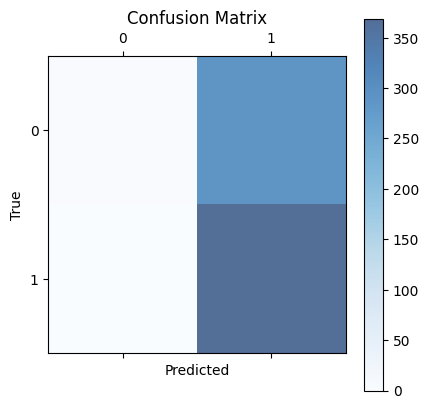

In [5]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


6. Multiple Inputs and Features

In [6]:
# Add lagged features (previous day percentage changes)
data['SP500_Lag'] = data['SP500_Change'].shift(1)
data['ASX200_Lag'] = data['ASX200_Change'].shift(1)
data.dropna(inplace=True)

# Features with lagged values
X = data[['SP500_Change', 'ASX200_Change', 'SP500_Lag', 'ASX200_Lag']]
y = data['Direction']

# Split the data again with the new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model again
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy with lagged features: {accuracy}")


Accuracy with lagged features: 0.5694864048338368


An accuracy of 56.95% means the model is making correct predictions just over half the time, which suggests it captures some relationships between the independent and dependent variables, but it is not highly reliable.

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest MSE: {mse}")
print(f"Random Forest R-squared: {r2}")


Random Forest MSE: 0.230557250755287
Random Forest R-squared: 0.06610163598047913


Random Forest has a positive R-squared (0.0661), indicating that the model is explaining about 6.61% of the variance in the target variable (NZX 50), but this is still quite low.

In [10]:
import xgboost as xgb

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
xgb_model = xgb.train({}, dtrain, num_boost_round=100)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(dtest)

# Evaluate the model performance
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost R-squared: {xgb_r2}")


XGBoost MSE: 0.25522268605792264
XGBoost R-squared: -0.03380858898162842


XGBoost has a negative R-squared (-0.0338), which means the model is performing worse than a simple mean-based prediction (i.e., it's a poor fit).


Correlation matrix to examine the correlation between the NZX 50 and the S&P 500 and ASX 200

[*********************100%***********************]  3 of 3 completed
<ipython-input-11-9e6f3dc17e32>:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df.pct_change().dropna()


Ticker     ^AXJO     ^GSPC     ^NZ50
Ticker                              
^AXJO   1.000000  0.405455  0.433802
^GSPC   0.405455  1.000000  0.224038
^NZ50   0.433802  0.224038  1.000000


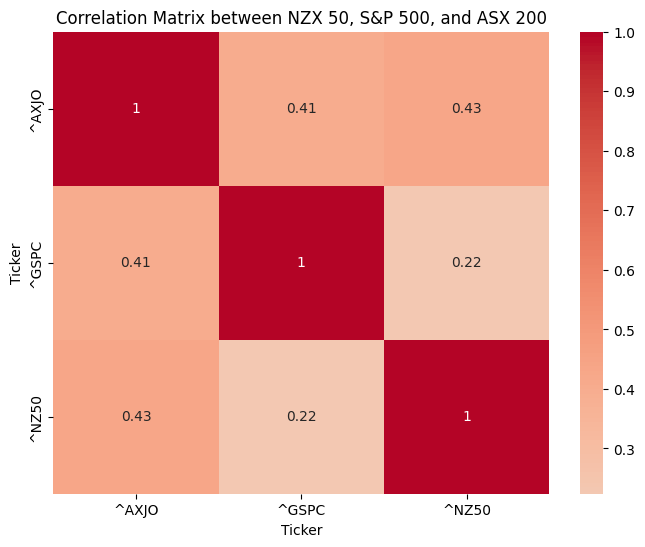

In [11]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt


data = yf.download(["^NZ50", "^GSPC", "^AXJO"], start="2020-01-01", end="2024-01-01")
df = data['Adj Close']
df_returns = df.pct_change().dropna()
correlation_matrix = df_returns.corr()
print(correlation_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix between NZX 50, S&P 500, and ASX 200")
plt.show()


**Conclusion**: While there is some influence of S&P 500 and CAC 40 on the FTSE 100, the overall predictive ability of these indices is limited. The moderate correlation and lower-than-expected model performance suggest that other factors, such as domestic economic conditions or specific global events, likely play a more significant role in FTSE 100 movements.